In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import pandas

In [3]:
od.download("https://www.kaggle.com/datasets/aneerbanchakraborty/face-mask-detection-data")

Skipping, found downloaded files in "./face-mask-detection-data" (use force=True to force download)


## **Setup**

In [4]:
import numpy as np 
import pandas as pd 
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers



In [5]:
with_maskImage = os.listdir('/content/face-mask-detection-data/with_mask')
without_maskImage = os.listdir('/content/face-mask-detection-data/without_mask')

In [6]:
print(len(with_maskImage))
print(len(without_maskImage))

1915
1918


## **Create a dataset**

In [7]:
batch_size = 16
img_height = 200
img_width = 200


In [8]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/face-mask-detection-data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 3833 files belonging to 2 classes.
Using 3067 files for training.


In [9]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/content/face-mask-detection-data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 3833 files belonging to 2 classes.
Using 766 files for validation.


In [10]:
class_names = training_ds.class_names
print(class_names)

['with_mask', 'without_mask']


### **Visualizing Training data**

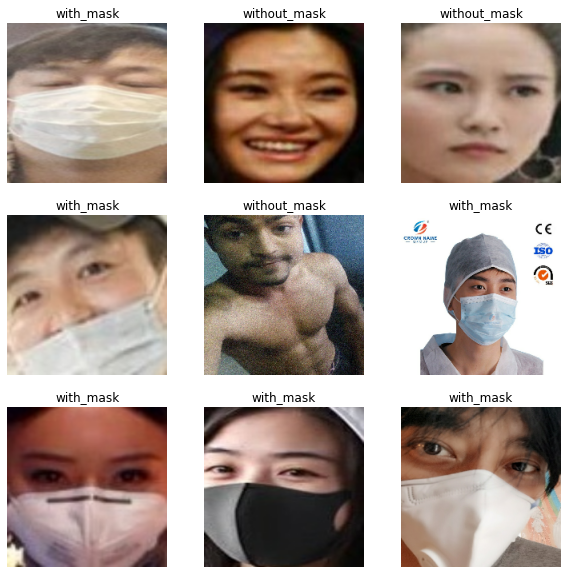

In [11]:
image_batch, label_batch = next(iter(training_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## **Configure the dataset for performance**
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

**.cache()** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

**.prefetch()** overlaps data preprocessing and model execution while training.

In [12]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Define CNN**

In [13]:
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(512, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])


In [14]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# **Train CNN**

In [15]:

model_saved = MyCnn.fit(training_ds, validation_data= testing_ds, epochs = 20)

MyCnn.save('mymodel.h5',model_saved)

Epoch 1/20
192/192 [==============================] - 13s 48ms/step - loss: 0.4670 - accuracy: 0.7842 - val_loss: 0.3421 - val_accuracy: 0.8616
Epoch 2/20
192/192 [==============================] - 4s 20ms/step - loss: 0.3351 - accuracy: 0.8732 - val_loss: 0.2341 - val_accuracy: 0.9191
Epoch 3/20
192/192 [==============================] - 4s 20ms/step - loss: 0.2877 - accuracy: 0.8934 - val_loss: 0.2523 - val_accuracy: 0.9125
Epoch 4/20
192/192 [==============================] - 4s 21ms/step - loss: 0.2476 - accuracy: 0.9048 - val_loss: 0.2176 - val_accuracy: 0.9269
Epoch 5/20
192/192 [==============================] - 4s 20ms/step - loss: 0.2416 - accuracy: 0.9110 - val_loss: 0.2355 - val_accuracy: 0.9178
Epoch 6/20
192/192 [==============================] - 4s 20ms/step - loss: 0.2272 - accuracy: 0.9129 - val_loss: 0.2278 - val_accuracy: 0.9204
Epoch 7/20
192/192 [==============================] - 4s 20ms/step - loss: 0.2120 - accuracy: 0.9240 - val_loss: 0.1955 - val_accuracy: 0.928

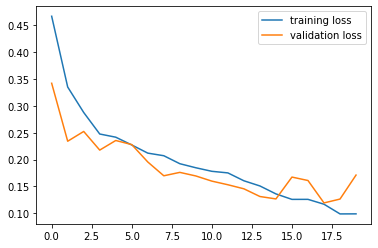

In [16]:
plt.plot(model_saved.history['loss'], label = 'training loss')
plt.plot(model_saved.history['val_loss'], label = 'validation loss')
plt.legend()

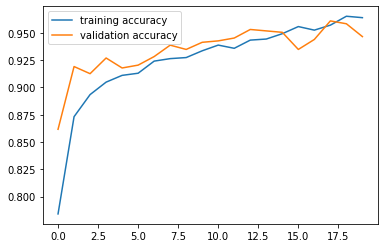

In [17]:
plt.plot(model_saved.history['accuracy'], label = 'training accuracy')
plt.plot(model_saved.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

### **Testing of model**

In [18]:
   
def LoadAndDetectObject(path, boxSize = 150, lim = 200):
    img = plt.imread(path)
    img = cv2.resize(img,(200,200))
    numplots = (lim / boxSize)*(lim /boxSize)
    stride = int ((lim - boxSize)/ boxSize)
    
    xCurPos = 0
    yCurPos = 0
    Red = img [:,:,0]
    Blue = img[:,:,1]
    Green = img[:,:,2]
    
    y_pos = 0
    i = 0
    while y_pos < lim:
        x_pos = 0
        while x_pos < lim:
            xCurPos = x_pos
            yCurPos = y_pos
            i += 1
            if i > numplots + 1000:
                cv2.putText(img, 'No Mask', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                plt.imshow(img)
                return
            
            
            r = Red[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            g = Blue[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            b = Green[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            
            ## sanity check
            xx, yy = r.shape
            if xx*yy != boxSize*boxSize:
                x_pos += stride
                continue
               
            imageSegment = cv2.merge((r,g,b))
            imageSegment  = np.array(imageSegment, dtype = 'uint8')
            imageSegment = cv2.resize(imageSegment, (lim, lim))
            result = (MyCnn.predict(np.array([imageSegment])))
            probab = max(result.flatten())
            result = (class_names[np.argmax(result)])
            #print(probab)
            
            if result == 'with_mask' and probab >= 0.8:
                probab = int (probab * 100) / 100
                img = cv2.rectangle(img, (xCurPos,yCurPos), (xCurPos + boxSize, yCurPos + boxSize), (0,255,0), 1) 
                cv2.putText(img, 'Mask', (xCurPos,yCurPos + boxSize), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
                plt.imshow(img)
                return
            
            
            
            
            x_pos += stride
        y_pos += stride
        
    cv2.putText(img, 'No Mask', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    plt.imshow(img)
    



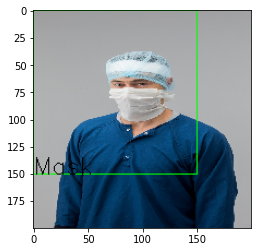

In [19]:
LoadAndDetectObject('/content/face-mask-detection-data/with_mask/image1,323.jpg')

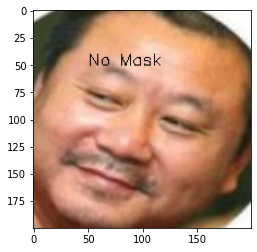

In [20]:
LoadAndDetectObject('/content/face-mask-detection-data/without_mask/Faceimg1,000.jpg')

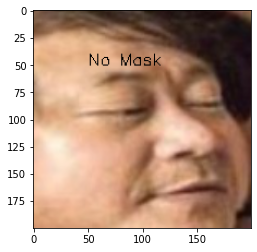

In [21]:
LoadAndDetectObject('/content/face-mask-detection-data/without_mask/Faceimg1,003.jpg')

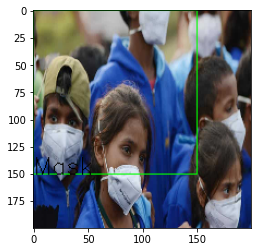

In [24]:
LoadAndDetectObject('/content/face-mask-detection-data/with_mask/image1,510.jpg')